<a href="https://colab.research.google.com/github/samanthajmichael/dsba6211-summer2024--project/blob/main/02_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing



In [1]:
%%capture
!pip install skorecard@git+https://github.com/wesslen/skorecard
!pip install --upgrade scikit-learn
!pip install datasets

## This uses the [HELOC dataset](https://huggingface.co/datasets/mstz/heloc) from the Huggingface API

In [414]:
import pandas as pd
from datasets import load_dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

heloc_dataset = load_dataset('mstz/heloc')
df = heloc_dataset['train'].to_pandas()
df_original = df.copy()
df = df_original.copy()
df.head()

,estimate_of_risk,months_since_first_trade,months_since_last_trade,average_duration_of_resolution,number_of_satisfactory_trades,nr_trades_insolvent_for_over_60_days,nr_trades_insolvent_for_over_90_days,percentage_of_legal_trades,months_since_last_illegal_trade,maximum_illegal_trades_over_last_year,maximum_illegal_trades,nr_total_trades,nr_trades_initiated_in_last_year,percentage_of_installment_trades,months_since_last_inquiry_not_recent,nr_inquiries_in_last_6_months,nr_inquiries_in_last_6_months_not_recent,net_fraction_of_revolving_burden,net_fraction_of_installment_burden,nr_revolving_trades_with_balance,nr_installment_trades_with_balance,nr_banks_with_high_ratio,percentage_trades_with_balance,is_at_risk
0,55,144,4,84,20,3,0,83,2,3,5,23,1,43,0,0,0,33,-8,8,1,1,69,1
1,61,58,15,41,2,4,4,100,-7,0,8,7,0,67,0,0,0,0,-8,0,-8,-8,0,1
2,67,66,5,24,9,0,0,100,-7,7,8,9,4,44,0,4,4,53,66,4,2,1,86,1
3,66,169,1,73,28,1,1,93,76,6,6,30,3,57,0,5,4,72,83,6,4,3,91,1
4,81,333,27,132,12,0,0,100,-7,7,8,12,0,25,0,1,1,51,89,3,1,0,80,1


In [415]:
df.dtypes

,0
estimate_of_risk,int8
months_since_first_trade,int32
months_since_last_trade,int32
average_duration_of_resolution,int32
number_of_satisfactory_trades,int16
nr_trades_insolvent_for_over_60_days,int16
nr_trades_insolvent_for_over_90_days,int16
percentage_of_legal_trades,int16
months_since_last_illegal_trade,int32
maximum_illegal_trades_over_last_year,int8


In [416]:
X = df[['estimate_of_risk', 'months_since_first_trade', 'months_since_last_trade', 'number_of_satisfactory_trades', 'nr_trades_insolvent_for_over_90_days',
        'percentage_of_legal_trades', 'months_since_last_illegal_trade', 'maximum_illegal_trades', 'nr_total_trades', 'nr_inquiries_in_last_6_months',
        'net_fraction_of_revolving_burden', 'nr_banks_with_high_ratio']]
y = df['is_at_risk']

## Partitioning

In [417]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# As with most real world data sets, some special values were encountered and were defined as follows: [-9,-8,-7]
- ## -9: indicates that the credit bureau report was not investigated or not found
- ## -8: denotes the absence of usable information
- ## -7: specifies that no information of that type was available at the time the sample was taken
## There were no missing values outside of the special values previously described

## Bucketing

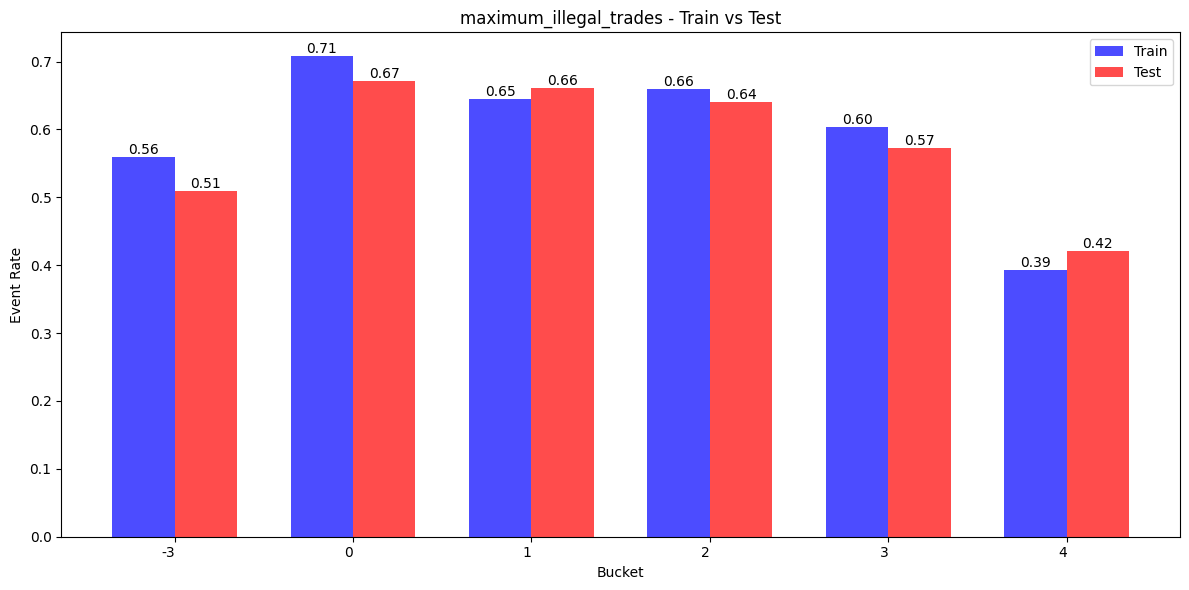

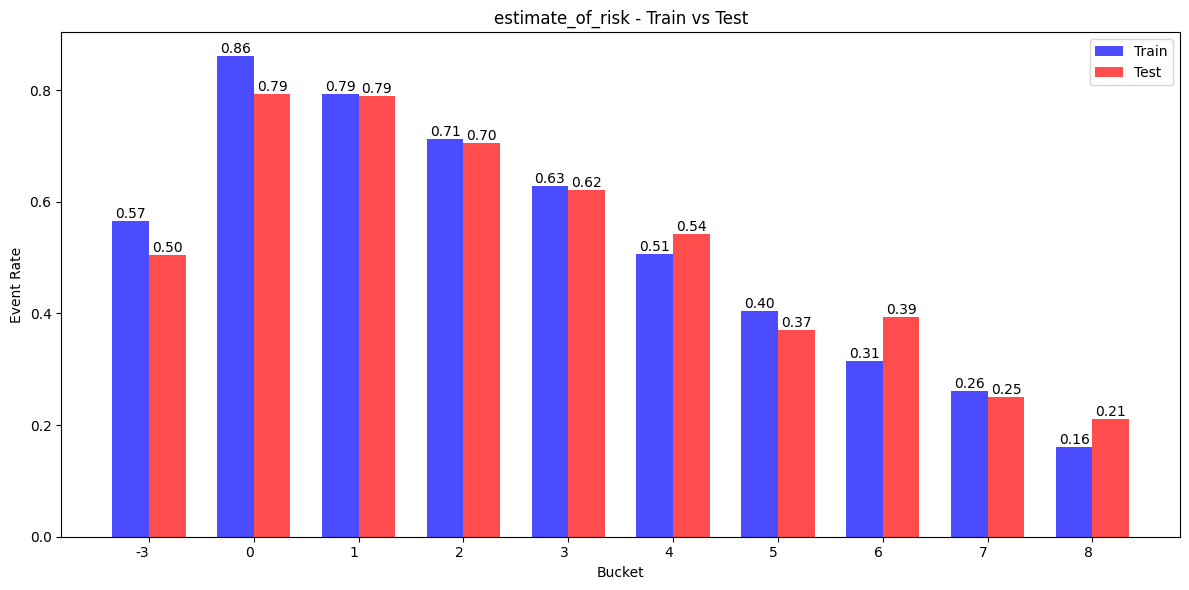

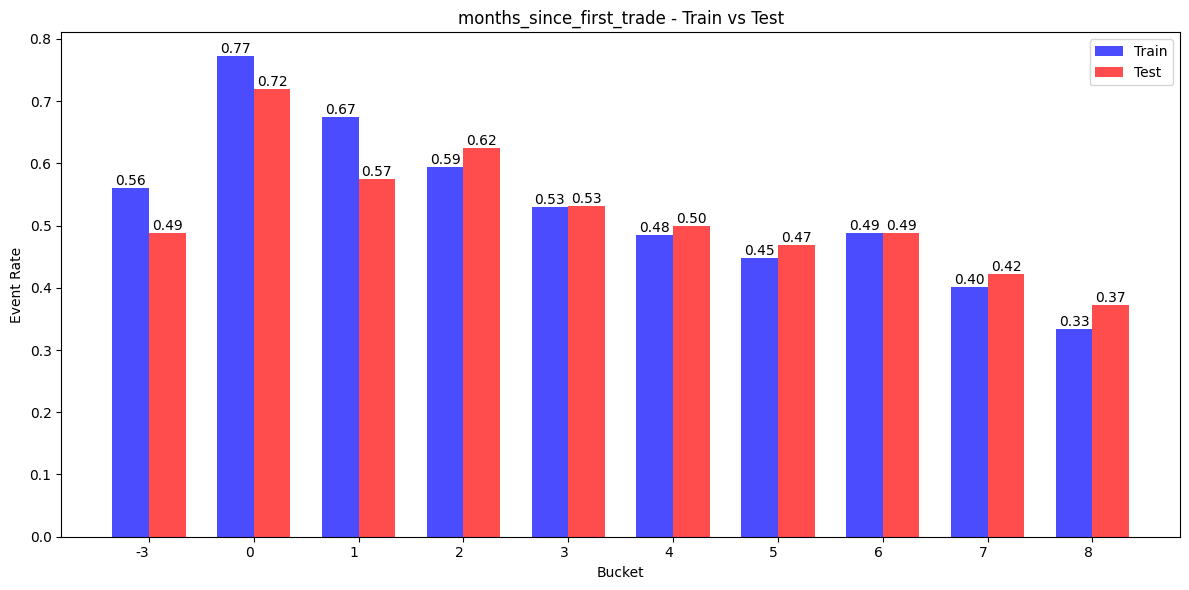

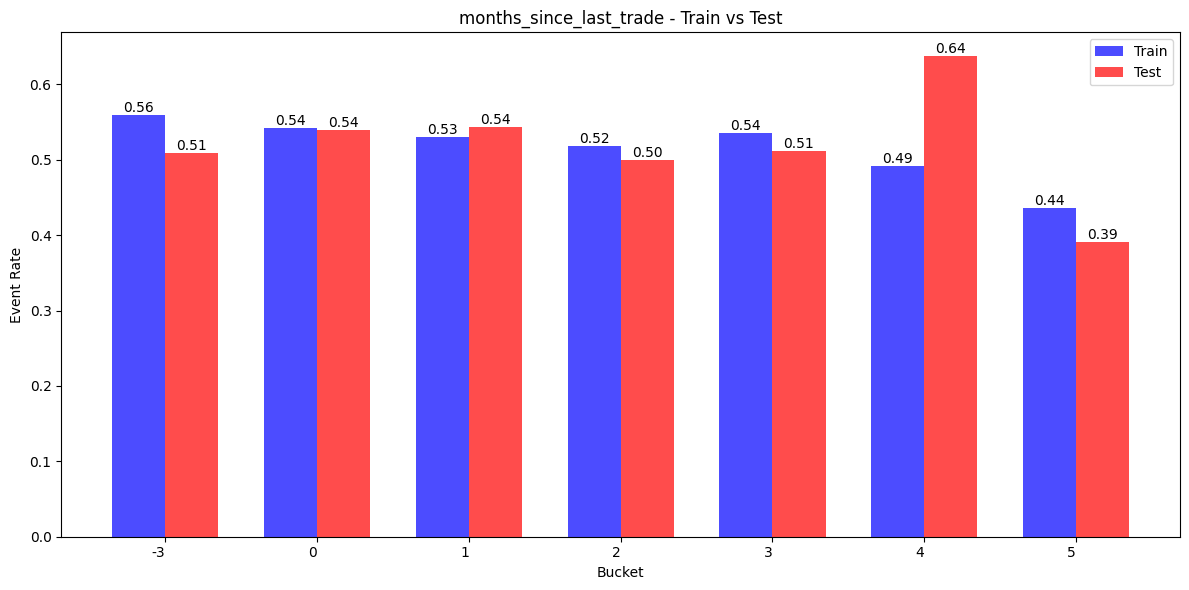

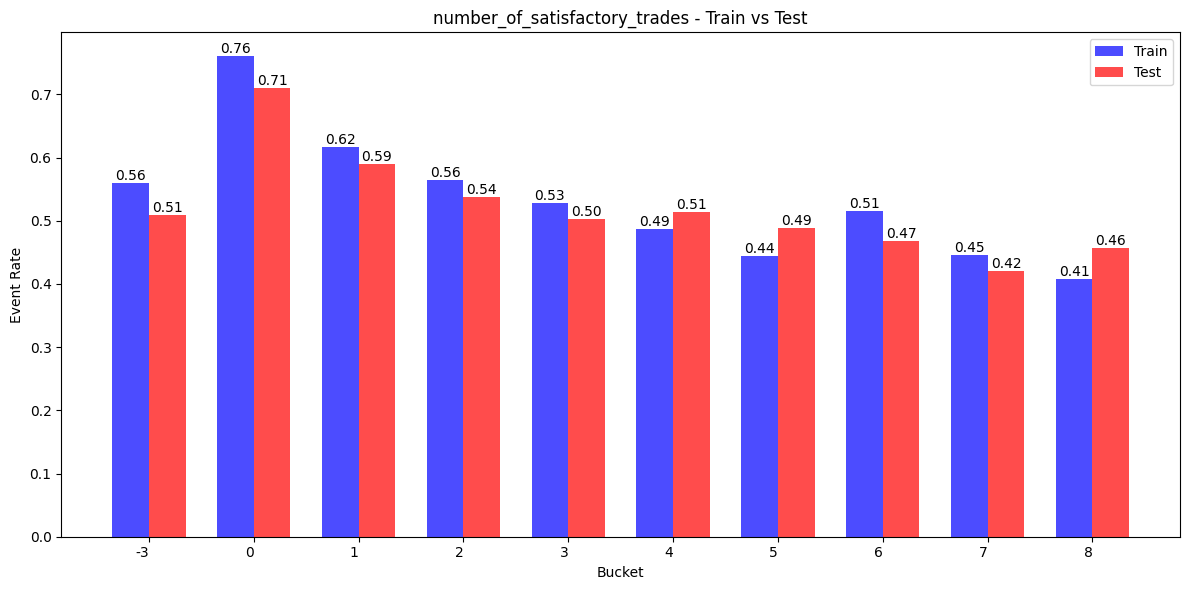

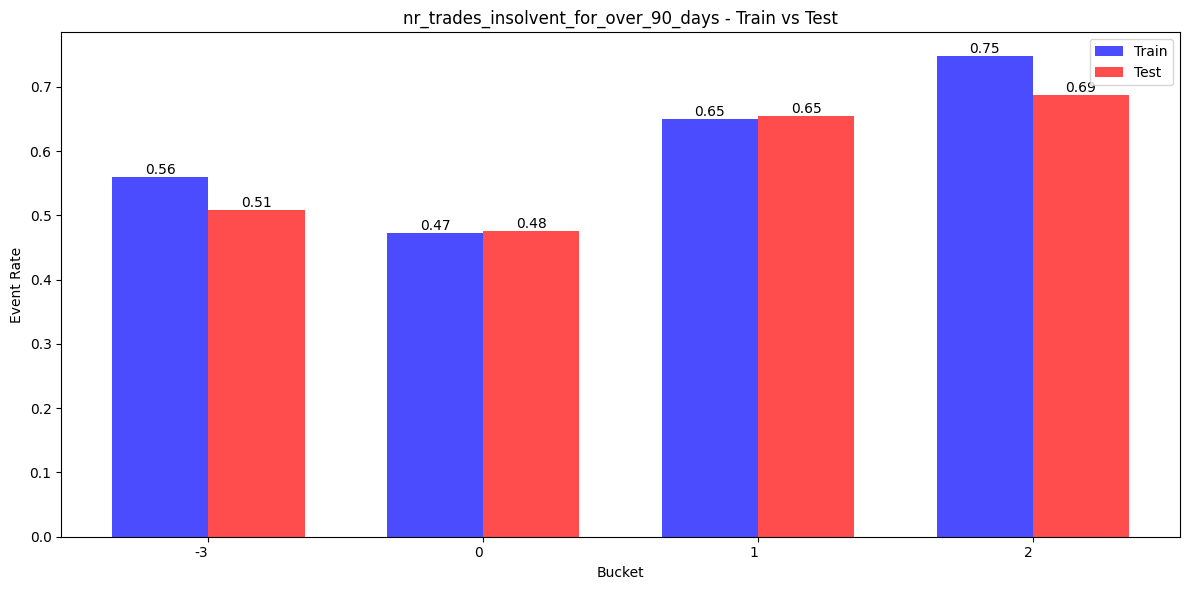

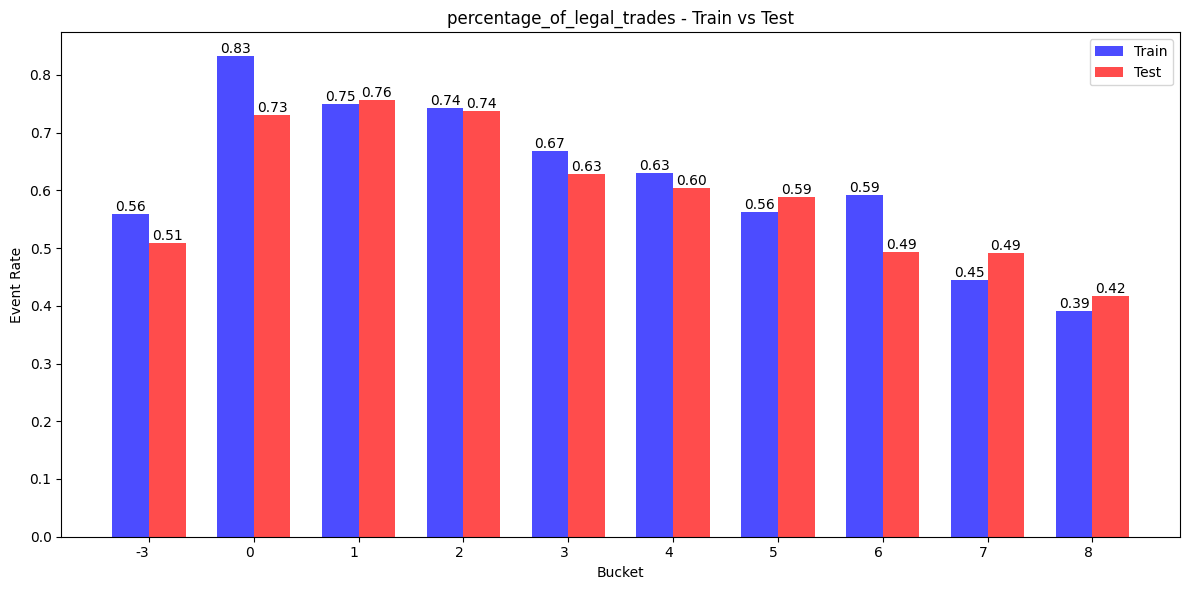

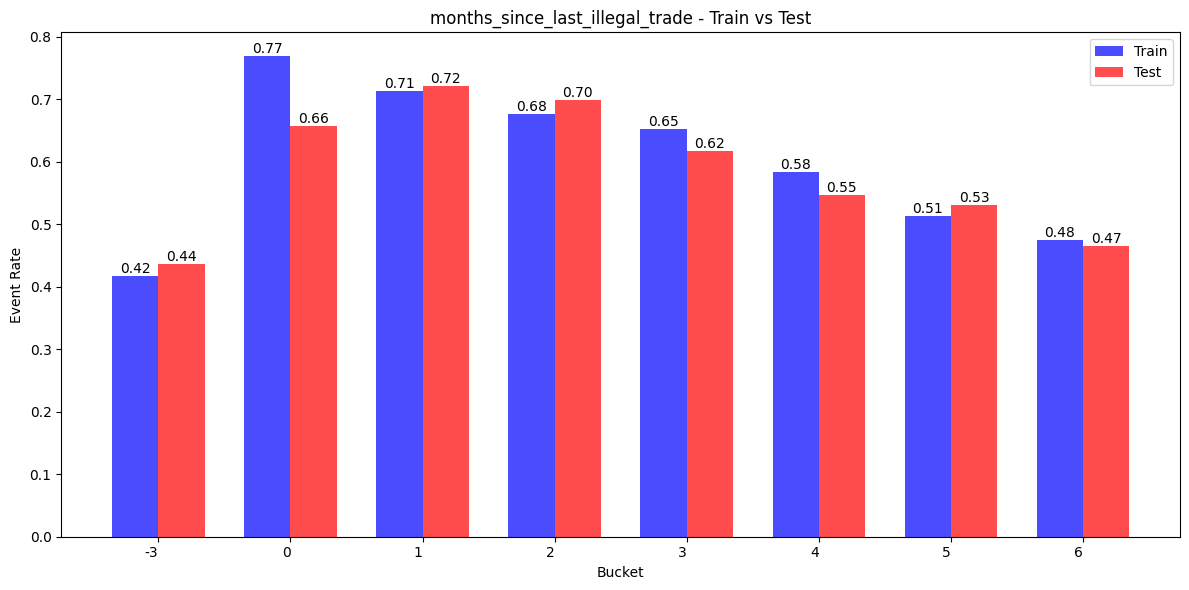

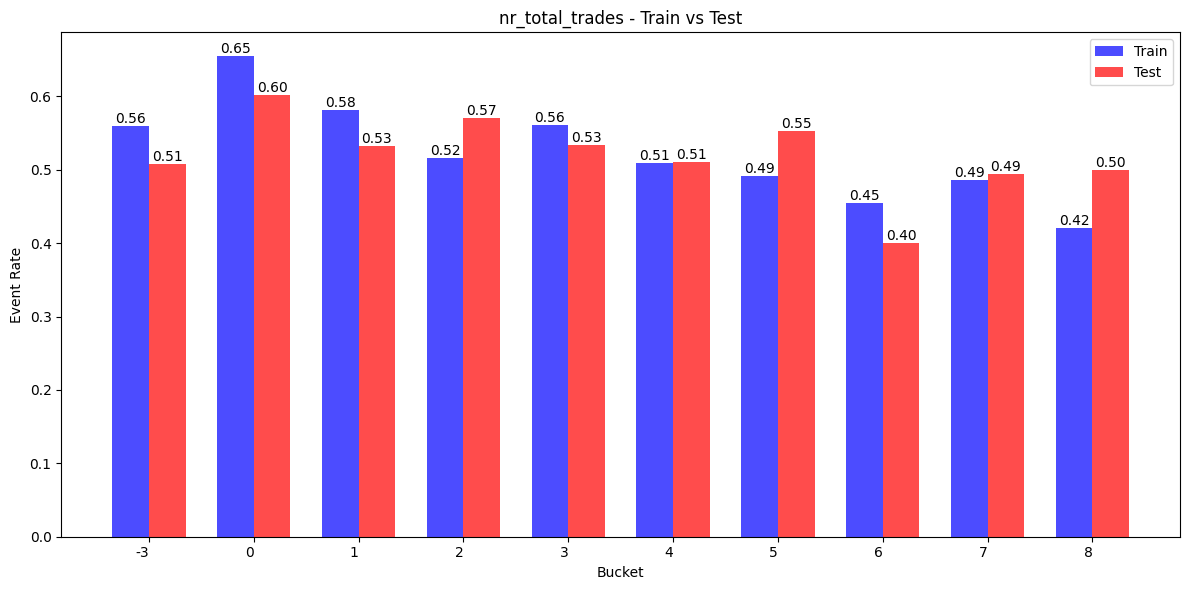

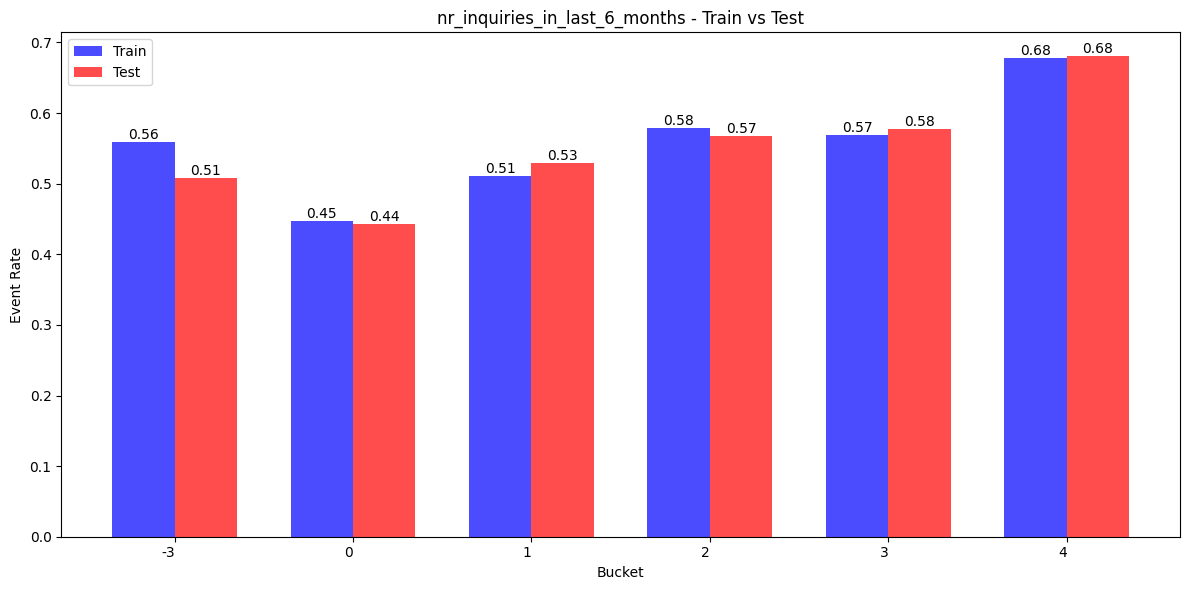

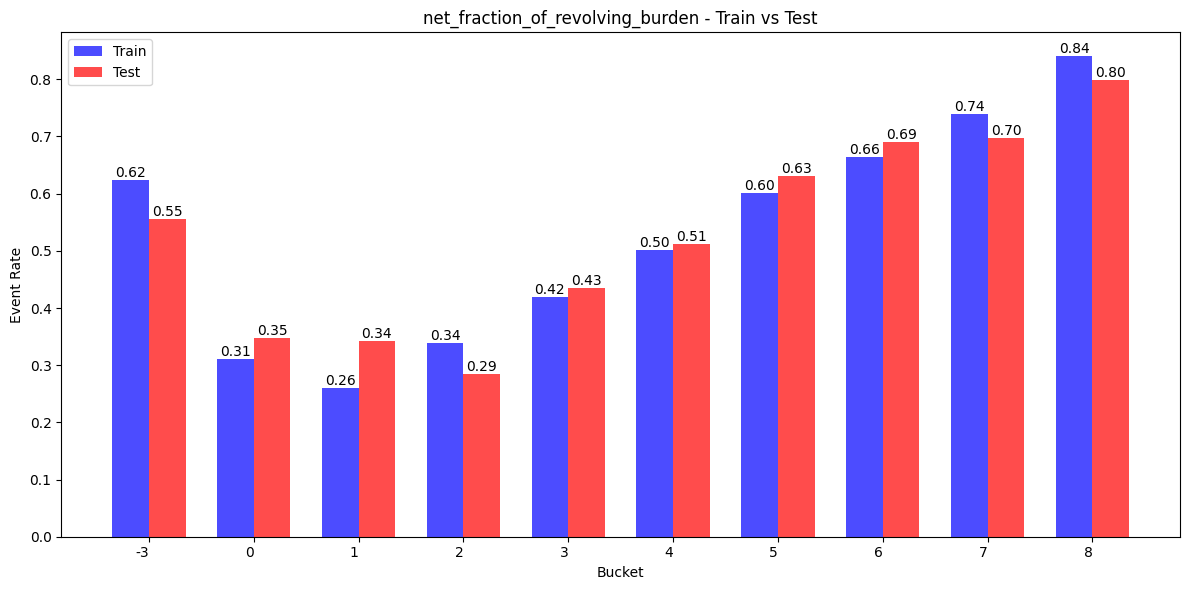

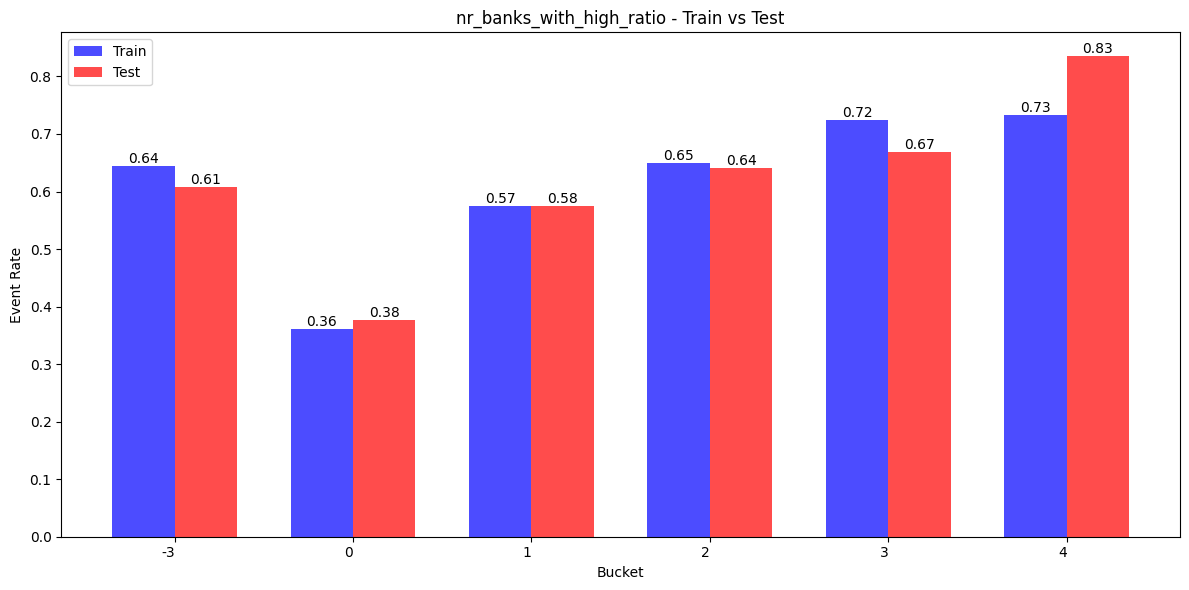

In [418]:
import warnings
warnings.filterwarnings("ignore")

from skorecard.bucketers import DecisionTreeBucketer, OptimalBucketer, EqualWidthBucketer
from skorecard.pipeline import BucketingProcess
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Special values definition
specials = {
    "maximum_illegal_trades": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "estimate_of_risk": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "months_since_first_trade":{'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "months_since_last_trade": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "number_of_satisfactory_trades": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "nr_trades_insolvent_for_over_90_days": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "percentage_of_legal_trades": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "months_since_last_illegal_trade": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "nr_total_trades": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "nr_inquiries_in_last_6_months": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "net_fraction_of_revolving_burden": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "nr_banks_with_high_ratio": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
}

num_cols = ['maximum_illegal_trades','estimate_of_risk', 'months_since_first_trade', 'months_since_last_trade', 'number_of_satisfactory_trades',
            'nr_trades_insolvent_for_over_90_days', 'percentage_of_legal_trades', 'months_since_last_illegal_trade', 'nr_total_trades',
            'nr_inquiries_in_last_6_months', 'net_fraction_of_revolving_burden', 'nr_banks_with_high_ratio']

# Create and fit bucketing process on training data
bucketing_process = BucketingProcess(
    prebucketing_pipeline=make_pipeline(
        EqualWidthBucketer(n_bins=100, variables=num_cols)
    ),
    bucketing_pipeline=make_pipeline(
        DecisionTreeBucketer(variables=num_cols, max_n_bins=10, min_bin_size=0.05, random_state=42)
    ),
    specials=specials
)
bucketing_process.fit(X_train, y_train)

def calculate_event_rates(X, y, variable):
    df = pd.DataFrame({'bucket': X[variable], 'target': y})
    event_rates = df.groupby('bucket')['target'].mean().reset_index()
    event_rates = event_rates.sort_values('bucket')
    return event_rates

def plot_grouped_buckets(bucketing_process, X_train, y_train, X_test, y_test, variable):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Transform data
    X_train_bucketed = bucketing_process.transform(X_train)
    X_test_bucketed = bucketing_process.transform(X_test)

    # Calculate event rates
    train_event_rates = calculate_event_rates(X_train_bucketed, y_train, variable)
    test_event_rates = calculate_event_rates(X_test_bucketed, y_test, variable)

    # Plot grouped bars
    x = np.arange(len(train_event_rates['bucket']))
    width = 0.35
    ax.bar(x - width/2, train_event_rates['target'], width, label='Train', color='blue', alpha=0.7)
    ax.bar(x + width/2, test_event_rates['target'], width, label='Test', color='red', alpha=0.7)

    # Set x-axis ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(train_event_rates['bucket'], ha='right')

    # Set labels and title
    ax.set_title(f'{variable} - Train vs Test')
    ax.set_xlabel('Bucket')
    ax.set_ylabel('Event Rate')
    ax.legend()

    # Add value labels on top of each bar
    for i, v in enumerate(train_event_rates['target']):
        ax.text(i - width/2, v, f'{v:.2f}', ha='center', va='bottom')
    for i, v in enumerate(test_event_rates['target']):
        ax.text(i + width/2, v, f'{v:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Plotting grouped bars (train and test) for all variables:
for col in num_cols:
    plot_grouped_buckets(bucketing_process, X_train, y_train, X_test, y_test, col)

# **Observation:**

## There are some slight differences in event rates between the train and test data but overall there is nothing egregious that would indicate poor performance.


# Exploring Buckets

## The event rate of the buckets provides important information about how the target variable is distributed within each bucket created by the bucketing process.

- ## **Risk Segmentation:** The event rate helps identify which buckets are associated with higher or lower risk.

  - ## A higher event rate in a bucket indicates a higher risk group.

- ## **Predictive Power:** Analyzing event rates across buckets demonstrates how well the features used for bucketing differentiate between different levels of risk.

  - ## There should be a clear separation, with some buckets having significantly higher or lower event rates.

- ## **Monotonicity:** the event rate should consistently increase or decrease. Monotonic changes in event rates across buckets suggest good feature selection and bucketing.

In [419]:
bucketing_process.summary()

,column,num_prebuckets,num_buckets,IV_score,dtype
0,estimate_of_risk,102,11,1.014141,int8
1,months_since_first_trade,102,11,0.245544,int32
2,months_since_last_trade,102,8,0.016511,int32
3,number_of_satisfactory_trades,102,11,0.129832,int16
4,nr_trades_insolvent_for_over_90_days,102,5,0.133343,int16
5,percentage_of_legal_trades,102,11,0.377671,int16
6,months_since_last_illegal_trade,102,9,0.289217,int32
7,maximum_illegal_trades,102,7,0.236075,int16
8,nr_total_trades,102,11,0.066561,int16
9,nr_inquiries_in_last_6_months,102,7,0.089966,int16


## Estimate of Risk

In [420]:
bucketing_process.bucket_table("estimate_of_risk")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-3,"Special: =NA, No Usable Data, Not Investigated",481.0,5.75,209.0,272.0,6.22,5.23,0.565,0.173,0.002
1,-1,Missing,0.0,0.00,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"[-inf, 43.5)",859.0,10.27,120.0,739.0,16.91,3.00,0.860,1.721,0.239
3,1,"[43.5, 50.0)",873.0,10.43,181.0,692.0,15.83,4.53,0.793,1.247,0.141
4,2,"[50.0, 57.0)",1079.0,12.90,310.0,769.0,17.59,7.76,0.713,0.817,0.080
5,3,"[57.0, 62.0)",824.0,9.85,307.0,517.0,11.83,7.68,0.627,0.430,0.018
6,4,"[62.0, 68.5)",1060.0,12.67,523.0,537.0,12.29,13.09,0.507,-0.063,0.001
7,5,"[68.5, 73.5)",709.0,8.47,423.0,286.0,6.54,10.59,0.403,-0.480,0.019
8,6,"[73.5, 78.5)",662.0,7.91,454.0,208.0,4.76,11.36,0.314,-0.868,0.057
9,7,"[78.5, 83.5)",586.0,7.00,433.0,153.0,3.50,10.84,0.261,-1.126,0.083


In [421]:
bucketing_process.plot_bucket("estimate_of_risk")

## Months Since First Trade

In [422]:
bucketing_process.bucket_table("months_since_first_trade")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-3,"Special: =NA, No Usable Data, Not Investigated",667.0,7.97,293.0,374.0,8.56,7.33,0.561,0.154,0.002
1,-1,Missing,0.0,0.00,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"[-inf, 10.5)",877.0,10.48,200.0,677.0,15.49,5.01,0.772,1.126,0.118
3,1,"[10.5, 14.5)",645.0,7.71,210.0,435.0,9.95,5.26,0.674,0.636,0.030
4,2,"[14.5, 16.5)",475.0,5.68,193.0,282.0,6.45,4.83,0.594,0.288,0.005
5,3,"[16.5, 20.5)",1207.0,14.43,568.0,639.0,14.62,14.21,0.529,0.028,0.000
6,4,"[20.5, 25.5)",1493.0,17.84,769.0,724.0,16.56,19.24,0.485,-0.150,0.004
7,5,"[25.5, 29.5)",753.0,9.00,416.0,337.0,7.71,10.41,0.448,-0.300,0.008
8,6,"[29.5, 32.5)",522.0,6.24,267.0,255.0,5.83,6.68,0.489,-0.135,0.001
9,7,"[32.5, 42.5)",1046.0,12.50,626.0,420.0,9.61,15.67,0.402,-0.488,0.030


In [423]:
bucketing_process.plot_bucket("months_since_first_trade")

## Months Since Last Trade

In [424]:
bucketing_process.bucket_table("months_since_last_trade")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-3,"Special: =NA, No Usable Data, Not Investigated",472.0,5.64,208.0,264.0,6.04,5.21,0.559,0.148,0.001
1,-1,Missing,0.0,0.00,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"[-inf, 0.5)",2401.0,28.70,1099.0,1302.0,29.79,27.50,0.542,0.080,0.002
3,1,"[0.5, 1.5)",2309.0,27.60,1086.0,1223.0,27.98,27.18,0.530,0.029,0.000
4,2,"[1.5, 2.5)",1207.0,14.43,581.0,626.0,14.32,14.54,0.519,-0.015,0.000
5,3,"[2.5, 3.5)",700.0,8.37,325.0,375.0,8.58,8.13,0.536,0.053,0.000
6,4,"[3.5, 4.5)",421.0,5.03,214.0,207.0,4.74,5.36,0.492,-0.123,0.001
7,5,"[4.5, inf)",857.0,10.24,483.0,374.0,8.56,12.09,0.436,-0.345,0.012


In [425]:
bucketing_process.plot_bucket("months_since_last_trade")

## Number of Satisfactory Trades

In [426]:
bucketing_process.bucket_table("number_of_satisfactory_trades")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-3,"Special: =NA, No Usable Data, Not Investigated",472.0,5.64,208.0,264.0,6.04,5.21,0.559,0.148,0.001
1,-1,Missing,0.0,0.00,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"[-inf, 7.5)",559.0,6.68,134.0,425.0,9.72,3.35,0.760,1.060,0.067
3,1,"[7.5, 14.0)",996.0,11.90,382.0,614.0,14.05,9.56,0.616,0.384,0.017
4,2,"[14.0, 16.5)",539.0,6.44,235.0,304.0,6.95,5.88,0.564,0.167,0.002
5,3,"[16.5, 23.0)",1484.0,17.74,701.0,783.0,17.91,17.54,0.528,0.021,0.000
6,4,"[23.0, 28.0)",1163.0,13.90,597.0,566.0,12.95,14.94,0.487,-0.143,0.003
7,5,"[28.0, 35.5)",1387.0,16.58,770.0,617.0,14.12,19.27,0.445,-0.311,0.016
8,6,"[35.5, 39.5)",474.0,5.67,230.0,244.0,5.58,5.76,0.515,-0.031,0.000
9,7,"[39.5, 48.5)",691.0,8.26,383.0,308.0,7.05,9.58,0.446,-0.307,0.008


In [427]:
bucketing_process.plot_bucket("number_of_satisfactory_trades")

## Trades Insolvent for Over 90 Days

In [428]:
bucketing_process.bucket_table('nr_trades_insolvent_for_over_90_days')

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-3,"Special: =NA, No Usable Data, Not Investigated",472.0,5.64,208.0,264.0,6.04,5.21,0.559,0.148,0.001
1,-1,Missing,0.0,0.00,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"[-inf, 3.0)",6126.0,73.22,3229.0,2897.0,66.28,80.81,0.473,-0.198,0.029
3,1,"[3.0, 9.0)",1155.0,13.80,404.0,751.0,17.18,10.11,0.650,0.529,0.037
4,2,"[9.0, inf)",614.0,7.34,155.0,459.0,10.50,3.88,0.748,0.992,0.066


In [429]:
bucketing_process.plot_bucket('nr_trades_insolvent_for_over_90_days')

## Percentage of Legal Trades

In [430]:
bucketing_process.bucket_table("percentage_of_legal_trades")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-3,"Special: =NA, No Usable Data, Not Investigated",472.0,5.64,208.0,264.0,6.04,5.21,0.559,0.148,0.001
1,-1,Missing,0.0,0.00,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"[-inf, 68.5)",435.0,5.20,73.0,362.0,8.28,1.83,0.832,1.501,0.097
3,1,"[68.5, 77.5)",442.0,5.28,111.0,331.0,7.57,2.78,0.749,0.997,0.048
4,2,"[77.5, 84.5)",564.0,6.74,145.0,419.0,9.59,3.63,0.743,0.967,0.058
5,3,"[84.5, 87.5)",440.0,5.26,146.0,294.0,6.73,3.65,0.668,0.607,0.019
6,4,"[87.5, 90.5)",487.0,5.82,180.0,307.0,7.02,4.50,0.630,0.442,0.011
7,5,"[90.5, 92.5)",482.0,5.76,211.0,271.0,6.20,5.28,0.562,0.160,0.001
8,6,"[92.5, 94.5)",588.0,7.03,240.0,348.0,7.96,6.01,0.592,0.281,0.005
9,7,"[94.5, 96.5)",638.0,7.63,354.0,284.0,6.50,8.86,0.445,-0.309,0.007


In [431]:
bucketing_process.plot_bucket("percentage_of_legal_trades")

## Months Since Last Illegal Trade

In [432]:
bucketing_process.bucket_table("months_since_last_illegal_trade")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-3,"Special: =NA, No Usable Data, Not Investigated",4341.0,51.88,2529.0,1812.0,41.46,63.29,0.417,-0.423,0.092
1,-1,Missing,0.0,0.00,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"[-inf, 3.5)",766.0,9.16,177.0,589.0,13.48,4.43,0.769,1.109,0.100
3,1,"[3.5, 9.5)",686.0,8.20,197.0,489.0,11.19,4.93,0.713,0.816,0.051
4,2,"[9.5, 15.5)",482.0,5.76,156.0,326.0,7.46,3.90,0.676,0.644,0.023
5,3,"[15.5, 24.5)",464.0,5.55,161.0,303.0,6.93,4.03,0.653,0.540,0.016
6,4,"[24.5, 37.5)",543.0,6.49,226.0,317.0,7.25,5.66,0.584,0.247,0.004
7,5,"[37.5, 56.5)",509.0,6.08,248.0,261.0,5.97,6.21,0.513,-0.039,0.000
8,6,"[56.5, inf)",576.0,6.88,302.0,274.0,6.27,7.56,0.476,-0.187,0.002


In [433]:
bucketing_process.plot_bucket("months_since_last_illegal_trade")

## Maximum Illegal Trades

In [434]:
bucketing_process.bucket_table("maximum_illegal_trades")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-3,"Special: =NA, No Usable Data, Not Investigated",472.0,5.64,208.0,264.0,6.04,5.21,0.559,0.148,0.001
1,-1,Missing,0.0,0.00,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"[-inf, 8.0)",578.0,6.91,169.0,409.0,9.36,4.23,0.708,0.791,0.041
3,1,"[8.0, 41.0)",502.0,6.00,178.0,324.0,7.41,4.45,0.645,0.507,0.015
4,2,"[41.0, 57.5)",773.0,9.24,263.0,510.0,11.67,6.58,0.660,0.571,0.029
5,3,"[57.5, 74.5)",2320.0,27.73,920.0,1400.0,32.03,23.02,0.603,0.330,0.030
6,4,"[74.5, inf)",3722.0,44.48,2258.0,1464.0,33.49,56.51,0.393,-0.523,0.120


In [435]:
bucketing_process.plot_bucket("maximum_illegal_trades")

## Total Trades

In [436]:
bucketing_process.bucket_table("nr_total_trades")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-3,"Special: =NA, No Usable Data, Not Investigated",472.0,5.64,208.0,264.0,6.04,5.21,0.559,0.148,0.001
1,-1,Missing,0.0,0.00,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"[-inf, 7.5)",889.0,10.63,307.0,582.0,13.32,7.68,0.655,0.548,0.031
3,1,"[7.5, 12.5)",1036.0,12.38,433.0,603.0,13.80,10.84,0.582,0.241,0.007
4,2,"[12.5, 14.5)",527.0,6.30,255.0,272.0,6.22,6.38,0.516,-0.025,0.000
5,3,"[14.5, 16.5)",586.0,7.00,257.0,329.0,7.53,6.43,0.561,0.156,0.002
6,4,"[16.5, 20.5)",1032.0,12.33,507.0,525.0,12.01,12.69,0.509,-0.055,0.000
7,5,"[20.5, 25.5)",1434.0,17.14,730.0,704.0,16.11,18.27,0.491,-0.126,0.003
8,6,"[25.5, 32.5)",1117.0,13.35,609.0,508.0,11.62,15.24,0.455,-0.271,0.010
9,7,"[32.5, 41.5)",739.0,8.83,380.0,359.0,8.21,9.51,0.486,-0.146,0.002


In [437]:
bucketing_process.plot_bucket("nr_total_trades")

## Inquiries in Last 6 Months

In [438]:
bucketing_process.bucket_table("nr_inquiries_in_last_6_months")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-3,"Special: =NA, No Usable Data, Not Investigated",472.0,5.64,208.0,264.0,6.04,5.21,0.559,0.148,0.001
1,-1,Missing,0.0,0.00,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"[-inf, 0.5)",3123.0,37.33,1725.0,1398.0,31.98,43.17,0.448,-0.300,0.034
3,1,"[0.5, 2.0)",2041.0,24.39,997.0,1044.0,23.88,24.95,0.512,-0.044,0.000
4,2,"[2.0, 3.5)",1207.0,14.43,509.0,698.0,15.97,12.74,0.578,0.226,0.007
5,3,"[3.5, 5.0)",612.0,7.31,264.0,348.0,7.96,6.61,0.569,0.186,0.003
6,4,"[5.0, inf)",912.0,10.90,293.0,619.0,14.16,7.33,0.679,0.656,0.045


In [439]:
bucketing_process.plot_bucket("nr_inquiries_in_last_6_months")

## Net Fraction of Revolving Burden

In [440]:
bucketing_process.bucket_table("net_fraction_of_revolving_burden")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-3,"Special: =NA, No Usable Data, Not Investigated",619.0,7.40,233.0,386.0,8.83,5.83,0.624,0.413,0.012
1,-1,Missing,0.0,0.00,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"[-inf, 0.5)",929.0,11.10,641.0,288.0,6.59,16.04,0.310,-0.888,0.084
3,1,"[0.5, 2.5)",726.0,8.68,537.0,189.0,4.32,13.44,0.260,-1.130,0.103
4,2,"[2.5, 5.5)",799.0,9.55,529.0,270.0,6.18,13.24,0.338,-0.760,0.054
5,3,"[5.5, 9.5)",929.0,11.10,540.0,389.0,8.90,13.51,0.419,-0.417,0.019
6,4,"[9.5, 15.5)",1133.0,13.54,564.0,569.0,13.02,14.11,0.502,-0.081,0.001
7,5,"[15.5, 21.5)",977.0,11.68,389.0,588.0,13.45,9.73,0.602,0.323,0.012
8,6,"[21.5, 26.5)",689.0,8.23,232.0,457.0,10.46,5.81,0.663,0.586,0.027
9,7,"[26.5, 33.5)",803.0,9.60,209.0,594.0,13.59,5.23,0.740,0.952,0.080


In [441]:
bucketing_process.plot_bucket("net_fraction_of_revolving_burden")

## Banks with High Ratio

In [442]:
bucketing_process.bucket_table("nr_banks_with_high_ratio")

,bucket,label,Count,Count (%),Non-event,Event,% Event,% Non-event,Event Rate,WoE,IV
0,-3,"Special: =NA, No Usable Data, Not Investigated",936.0,11.19,333.0,603.0,13.80,8.33,0.644,0.503,0.027
1,-1,Missing,0.0,0.00,0.0,0.0,0.00,0.00,NaN,NaN,NaN
2,0,"[-inf, 2.5)",3416.0,40.83,2184.0,1232.0,28.19,54.65,0.361,-0.662,0.175
3,1,"[2.5, 8.0)",2015.0,24.08,858.0,1157.0,26.47,21.47,0.574,0.209,0.010
4,2,"[8.0, 13.5)",983.0,11.75,345.0,638.0,14.60,8.63,0.649,0.524,0.031
5,3,"[13.5, 19.0)",496.0,5.93,137.0,359.0,8.21,3.43,0.724,0.869,0.042
6,4,"[19.0, inf)",521.0,6.23,139.0,382.0,8.74,3.48,0.733,0.917,0.048


In [443]:
bucketing_process.plot_bucket("nr_banks_with_high_ratio")

# Interpretation

- ## There is a distinct separation, with some buckets showing notably higher or lower event rates.

- ## The event rates change monotonically across buckets for each feature, suggesting good feature selection and bucketing.


#Model Training

In [444]:
from skorecard.pipeline import to_skorecard_pipeline
bucketing_process.save_yml(open("buckets.yml", "w"))

In [445]:
import yaml

buckets_dict = yaml.safe_load(open("buckets.yml"))

buckets_dict

{'estimate_of_risk': {'feature_name': 'estimate_of_risk',
  'map': [59.4,
   63.0,
   67.19999999999999,
   70.19999999999999,
   74.4,
   77.4,
   80.4,
   83.4],
  'missing_bucket': None,
  'other_bucket': None,
  'right': True,
  'specials': {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
  'type': 'numerical'},
 'maximum_illegal_trades': {'feature_name': 'maximum_illegal_trades',
  'map': [2.48, 4.46, 5.48, 6.5],
  'missing_bucket': None,
  'other_bucket': None,
  'right': True,
  'specials': {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
  'type': 'numerical'},
 'months_since_first_trade': {'feature_name': 'months_since_first_trade',
  'map': [90.11,
   122.14999999999999,
   138.17,
   170.21,
   210.26,
   242.29999999999998,
   266.33,
   346.43],
  'missing_bucket': None,
  'other_bucket': None,
  'right': True,
  'specials': {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
  'type': 'numerical'},
 'months_since_last_illegal_trade': {'feature_name': 

In [446]:
from skorecard import Skorecard
from skorecard.bucketers import UserInputBucketer

scorecard = Skorecard(bucketing=UserInputBucketer(buckets_dict), variables=num_cols, calculate_stats=True)
scorecard = scorecard.fit(X_train, y_train)

In [447]:
scorecard

Skorecard(bucketing=UserInputBucketer, specials={}, encoder=woe, variables=['maximum_illegal_trades', 'estimate_of_risk', 'months_since_first_trade', 'months_since_last_trade', 'number_of_satisfactory_trades', 'nr_trades_insolvent_for_over_90_days', 'percentage_of_legal_trades', 'months_since_last_illegal_trade', 'nr_total_trades', 'nr_inquiries_in_last_6_months', 'net_fraction_of_revolving_burden', 'nr_banks_with_high_ratio'], verbose=0, random_state=None, lr_kwargs={'solver': 'lbfgs'}, calculate_stats=True, classes_=[0 1], bucketing_=UserInputBucketer(features_bucket_mapping={'estimate_of_risk': {'feature_name': 'estimate_of_risk',
                                                                'map': [59.4,
                                                                        63.0,
                                                                        67.19999999999999,
                                                                        70.19999999999999,
                                                                        74.4,
                                                                        77.4,
                                                                        80.4,
                                                                        83.4],
                                                                'missing_bucket': None,
                                                                'other_bucket': None,
                                                                'right': True,
                                                                'specials': {'=NA, No Usable Data, Not Investigated': [-7,
                                                                                                                       -8,
                                                                                                                       -9]},
                                                                'type': 'numerical'},
                                           'maximum_illegal_trades': {'feature_name': 'max...
                                                                             'other_bucket': None,
                                                                             'right': True,
                                                                             'specials': {'=NA, No Usable Data, Not Investigated': [-7,
                                                                                                                                    -8,
                                                                                                                                    -9]},
                                                                             'type': 'numerical'},
                                           'percentage_of_legal_trades': {'feature_name': 'percentage_of_legal_trades',
                                                                          'map': [69.0,
                                                                                  78.0,
                                                                                  85.0,
                                                                                  88.0,
                                                                                  91.0,
                                                                                  93.0,
                                                                                  95.0,
                                                                                  97.0],
                                                                          'missing_bucket': None,
                                                                          'other_bucket': None,
                                                                          'right': True,
                                                                          'specials': {'=NA, No

In [448]:
scorecard.pipeline_

Pipeline(steps=[('bucketer',
                 UserInputBucketer(features_bucket_mapping={'estimate_of_risk': {'feature_name': 'estimate_of_risk',
                                                                                 'map': [59.4,
                                                                                         63.0,
                                                                                         67.19999999999999,
                                                                                         70.19999999999999,
                                                                                         74.4,
                                                                                         77.4,
                                                                                         80.4,
                                                                                         83.4],
                                                                                 'missing_bucket': None,
                                                                                 'other_bucket': None,
                                                                                 'right': True,
                                                                                 'specials': {'=NA, No Usable Data, Not Investigated': [-7,
                                                                                                                                        -8,
                                                                                                                                        -9]},
                                                                                 'type': 'numerical'},
                                                            'maximum_illegal_...
                                           'months_since_first_trade',
                                           'months_since_last_trade',
                                           'number_of_satisfactory_trades',
                                           'nr_trades_insolvent_for_over_90_days',
                                           'percentage_of_legal_trades',
                                           'months_since_last_illegal_trade',
                                           'nr_total_trades',
                                           'nr_inquiries_in_last_6_months',
                                           'net_fraction_of_revolving_burden',
                                           'nr_banks_with_high_ratio'])),
                ('model', LogisticRegression(calculate_stats=True))])

In [449]:
#scorecard.get_params()

In [450]:
scorecard.get_stats()

,Coef.,Std.Err,z,P>|z|
const,0.076656,0.025570,2.997947,2.718048e-03
maximum_illegal_trades,-0.323430,0.103739,-3.117733,1.822478e-03
estimate_of_risk,0.480930,0.050313,9.558723,1.192189e-21
months_since_first_trade,0.573756,0.059744,9.603605,7.719597e-22
months_since_last_trade,0.256372,0.221766,1.156047,2.476621e-01
number_of_satisfactory_trades,0.749630,0.115498,6.490387,8.561607e-11
nr_trades_insolvent_for_over_90_days,0.031309,0.085343,0.366856,7.137266e-01
percentage_of_legal_trades,0.332566,0.080613,4.125492,3.699426e-05
months_since_last_illegal_trade,0.547896,0.085803,6.385500,1.708379e-10
nr_total_trades,0.046224,0.154867,0.298474,7.653416e-01


# Model Evaluation

In [451]:
from sklearn.metrics import roc_auc_score, classification_report

proba_train = scorecard.predict_proba(X_train)[:, 1]
proba_test = scorecard.predict_proba(X_test)[:, 1]

print(f"AUC train:{round(roc_auc_score(y_train, proba_train),4)}")
print(f"AUC test :{round(roc_auc_score(y_test, proba_test),4)}\n")

print(classification_report(y_test, scorecard.predict(X_test)))

AUC train:0.7956
AUC test :0.7535

              precision    recall  f1-score   support

           0       0.69      0.65      0.67      1004
           1       0.70      0.73      0.71      1088

    accuracy                           0.69      2092
   macro avg       0.69      0.69      0.69      2092
weighted avg       0.69      0.69      0.69      2092



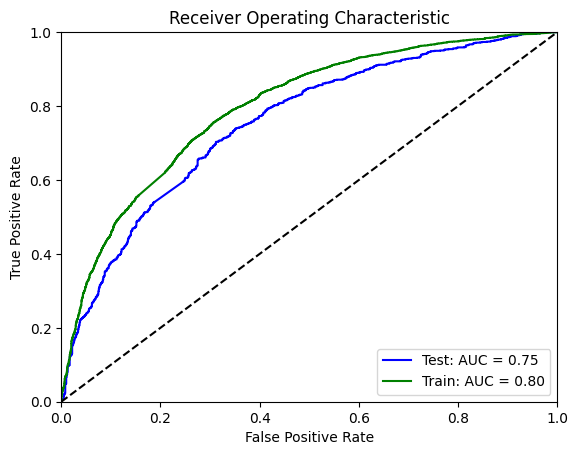

In [452]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr1, tpr1, threshold1 = roc_curve(y_test, proba_test)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, threshold2 = roc_curve(y_train, proba_train)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='Test: AUC = {0:.2f}'.format(roc_auc1))
plt.plot(fpr2, tpr2, 'g', label='Train: AUC = {0:.2f}'.format(roc_auc2))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Observation:**
- ## There is a 5% decrease in the AUC from the train to the test, indicating a potential issue with the model's generalization.

- ## This drop suggests that the model may be overfitting to the training data or there could be issues with data quality or feature selection.

- ## Further investigation is needed to address these issues and improve the model's performance on unseen data

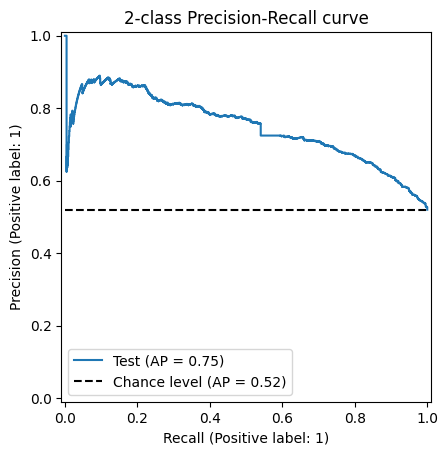

In [453]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    scorecard, X_test, y_test, name="Test", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Feature Importance

In [454]:
from skorecard.reporting import iv

model_stats = scorecard.get_stats()

X_train_bins = scorecard.bucket_transform(X_train)
iv_dict = iv(X_train_bins, y_train)

iv_values = pd.Series(iv_dict).sort_values(ascending=False)
iv_values.name = "IV"

feat_importance = model_stats[["Coef."]].join(iv_values)
feat_importance["importance"] = -1.0 * feat_importance["Coef."] * feat_importance["IV"]
feat_importance.sort_values(by="importance", ascending=False)

,Coef.,IV,importance
maximum_illegal_trades,-0.323430,0.236075,0.076354
nr_total_trades,0.046224,0.066561,-0.003077
nr_trades_insolvent_for_over_90_days,0.031309,0.133343,-0.004175
months_since_last_trade,0.256372,0.016511,-0.004233
nr_inquiries_in_last_6_months,0.620783,0.089966,-0.055850
nr_banks_with_high_ratio,0.201265,0.334577,-0.067339
number_of_satisfactory_trades,0.749630,0.129832,-0.097326
percentage_of_legal_trades,0.332566,0.377671,-0.125601
months_since_first_trade,0.573756,0.245544,-0.140882
months_since_last_illegal_trade,0.547896,0.289217,-0.158460


The general [rule](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html), is IV > 0.02 should be included.

| Information Value | Variable Predictiveness     |
|:-----------------:|-----------------------------|
|   Less than 0.02  | Not useful for prediction   |
|    0.02 to 0.1    | Weak predictive Power       |
|     0.1 to 0.3    | Medium predictive Power     |
|     0.3 to 0.5    | Strong predictive Power     |
|       > 0.5       | Suspicious Predictive Power |

## **Observations:**
## *IV:*
- ## All the variables have IV values greater than 0.02 and will be considered for inclusion in the model.

## *Importance:* the variables in the table are sorted by their importance in descending order, but for this analysis, the absolute value of each variable's importance is considered more important.
- ## **High Importance:** Features with higher importance values are generally more influential in the model and contribute significantly to the model's predictive power.

  - ## estimate_of_risk (-0.487731)
  - ## months_since_first_trade (-0.140882)
  - ## percentage_of_legal_trades (-0.125601)
  - ## number_of_satisfactory_trades (-0.097326)
  
- ## **Moderate Importance:** Features with moderate importance values can be considered for the model if they contribute without adding excessive complexity.

  - ## nr_banks_with_high_ratio (-0.067339)
  - ## nr_inquiries_in_last_6_months (-0.055850)

- ## **Low Importance:** Features with low importance may have minimal impact on the model's performance. While they might be excluded, it's worth assessing their relevance and considering them if they provide valuable insights or improve model stability.

  - ## months_since_last_trade (-0.004233)
  - ## nr_trades_insolvent_for_over_90_days (-0.004175)

# Multicollinearity

In [455]:
import yaml

buckets_dict = yaml.safe_load(open("buckets.yml"))

In [456]:
from skorecard.bucketers import UserInputBucketer

uib = UserInputBucketer(buckets_dict)

In [457]:
X_train_bins = uib.fit_transform(X_train, y_train)
X_test_bins = uib.transform(X_test)

In [458]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


def plot_correlations(corr):
    plt.figure(figsize=(10, 8), constrained_layout=True)

    cmap = plt.cm.get_cmap("RdBu")
    matrix = np.triu(corr)
    sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask=matrix, cmap=cmap, annot_kws={"fontsize": 6})

In [459]:
from skorecard.preprocessing import WoeEncoder
from sklearn.pipeline import make_pipeline

woe_pipe = make_pipeline(uib, WoeEncoder())

In [460]:
X_train_woe = woe_pipe.fit_transform(X_train, y_train)

In [461]:
preselected_features = ['estimate_of_risk', 'months_since_first_trade', 'months_since_last_trade', 'number_of_satisfactory_trades', 'nr_trades_insolvent_for_over_90_days',
        'percentage_of_legal_trades', 'months_since_last_illegal_trade', 'maximum_illegal_trades', 'nr_total_trades', 'nr_inquiries_in_last_6_months',
        'net_fraction_of_revolving_burden', 'nr_banks_with_high_ratio']

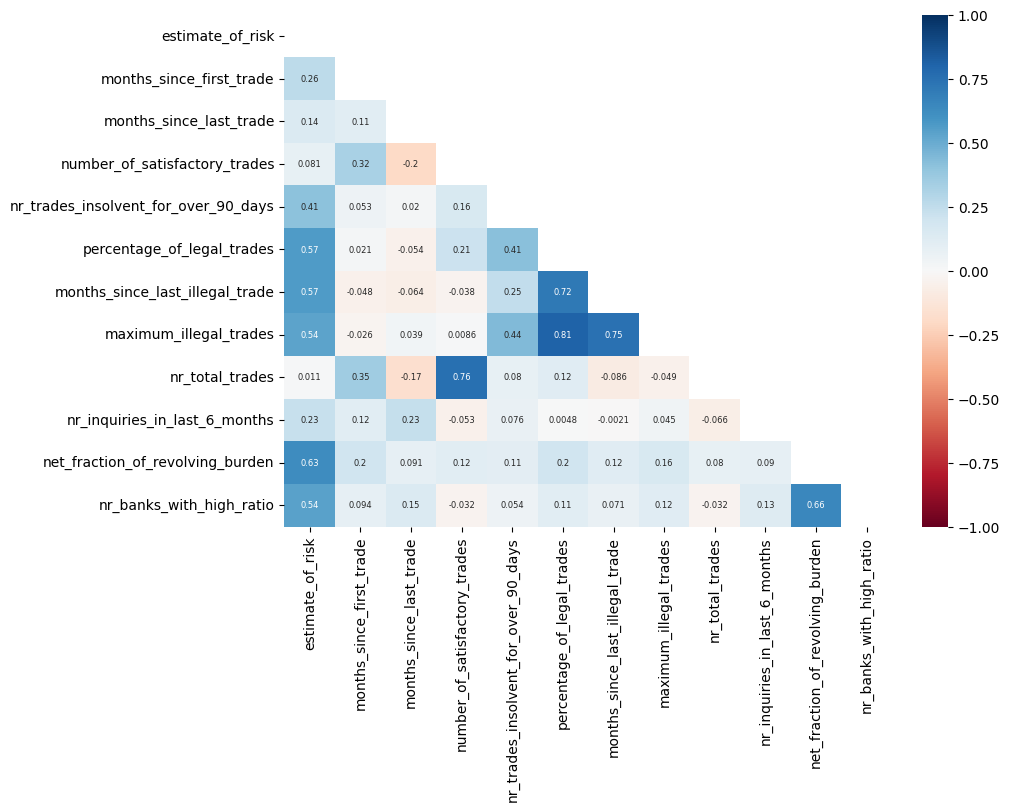

In [462]:
X_train_corr = X_train_woe[preselected_features].corr()
plot_correlations(X_train_corr)

In [463]:
corr_limit = 0.6  # correlation threshold

drop_feats = list()

# keep_feats = list()

for ix, feature in enumerate(preselected_features):
    if feature in drop_feats:
        continue

    remaining_features = [
        feat
        for feat in preselected_features[ix:]  # check the next feature in the preselected step
        if feat not in drop_feats and feat != feature
    ]
    if len(remaining_features) == 0:
        continue  # go to the next step if the features at step x have already been removeed

    # find the correlated features with the remaining preselected features
    # both positive and negative correlations matter, hence the abs()
    corr_feats = X_train_corr.loc[remaining_features, feature].apply(lambda x: abs(x))

    drop_at_step = corr_feats[corr_feats > corr_limit].index.tolist()

    # append the new features to the list
    drop_feats += drop_at_step

# Select the features with low correlations
good_feats = [feat for feat in preselected_features if feat not in drop_feats]

print(f"Total preselected features: {len(preselected_features)}")
print(f"Total features dropped due too high correlations: {len(drop_feats)}")
print(f"Total selected features: {len(good_feats)}")

Total preselected features: 12
Total features dropped due too high correlations: 4
Total selected features: 8


In [464]:
drop_feats

['net_fraction_of_revolving_burden',
 'nr_total_trades',
 'months_since_last_illegal_trade',
 'maximum_illegal_trades']

In [465]:
good_feats

['estimate_of_risk',
 'months_since_first_trade',
 'months_since_last_trade',
 'number_of_satisfactory_trades',
 'nr_trades_insolvent_for_over_90_days',
 'percentage_of_legal_trades',
 'nr_inquiries_in_last_6_months',
 'nr_banks_with_high_ratio']

# Retraining the Model Using the Best Features

In [466]:
df = df_original.copy()

features = ['estimate_of_risk', 'months_since_first_trade', 'months_since_last_trade', 'number_of_satisfactory_trades',
            'nr_trades_insolvent_for_over_90_days', 'percentage_of_legal_trades',
            'nr_inquiries_in_last_6_months', 'nr_banks_with_high_ratio']
X = df[features]
y = df['is_at_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [467]:
import warnings
warnings.filterwarnings("ignore")

# Special values definition
specials = {
    "estimate_of_risk": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "months_since_first_trade":{'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "months_since_last_trade": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "number_of_satisfactory_trades": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "nr_trades_insolvent_for_over_90_days": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "percentage_of_legal_trades": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "nr_inquiries_in_last_6_months": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
    "nr_banks_with_high_ratio": {'=NA, No Usable Data, Not Investigated': [-7, -8, -9]},
}

num_cols = ['estimate_of_risk', 'months_since_first_trade', 'months_since_last_trade', 'number_of_satisfactory_trades',
            'nr_trades_insolvent_for_over_90_days', 'percentage_of_legal_trades',
            'nr_inquiries_in_last_6_months', 'nr_banks_with_high_ratio']

# Create and fit bucketing process on training data
bucketing_process = BucketingProcess(
    prebucketing_pipeline=make_pipeline(
        EqualWidthBucketer(n_bins=100, variables=num_cols)
    ),
    bucketing_pipeline=make_pipeline(
        DecisionTreeBucketer(variables=num_cols, max_n_bins=10, min_bin_size=0.05, random_state=42)
    ),
    specials=specials
)
bucketing_process.fit(X_train, y_train)

BucketingProcess(bucketing_pipeline=Pipeline(steps=[('decisiontreebucketer',
                                                     DecisionTreeBucketer(max_n_bins=10,
                                                                          random_state=42,
                                                                          variables=['estimate_of_risk',
                                                                                     'months_since_first_trade',
                                                                                     'months_since_last_trade',
                                                                                     'number_of_satisfactory_trades',
                                                                                     'nr_trades_insolvent_for_over_90_days',
                                                                                     'percentage_of_legal_trades',
                                                                                     'nr_inquiries_in_last_6_months',
                                                                                     'nr_bank...
                           'nr_banks_with_high_ratio': {'=NA, No Usable Data, Not Investigated': [-7,
                                                                                                  -8,
                                                                                                  -9]},
                           'nr_inquiries_in_last_6_months': {'=NA, No Usable Data, Not Investigated': [-7,
                                                                                                       -8,
                                                                                                       -9]},
                           'nr_trades_insolvent_for_over_90_days': {'=NA, No Usable Data, Not Investigated': [-7,
                                                                                                              -8,
                                                                                                              -9]},
                           'number_of_satisfactory_trades': {'=NA, No Usable Data, Not Investigated': [-7,
                                                                                                       -8,
                                                                                                       -9]},
                           'percentage_of_legal_trades': {'=NA, No Usable Data, Not Investigated': [-7,
                                                                                                    -8,
                                                                                                    -9]}})

In [468]:
from skorecard.pipeline import to_skorecard_pipeline
bucketing_process.save_yml(open("buckets.yml", "w"))

In [469]:
import yaml

buckets_dict = yaml.safe_load(open("buckets.yml"))

In [470]:
from skorecard import Skorecard
from skorecard.bucketers import UserInputBucketer

scorecard = Skorecard(bucketing=UserInputBucketer(buckets_dict), variables=num_cols, calculate_stats=True)
scorecard = scorecard.fit(X_train, y_train)

In [471]:
scorecard.get_stats()

,Coef.,Std.Err,z,P>|z|
const,0.082860,0.025409,3.260997,1.110213e-03
estimate_of_risk,0.759356,0.039961,19.002535,1.625042e-80
months_since_first_trade,0.520725,0.057421,9.068600,1.205562e-19
months_since_last_trade,0.001725,0.215929,0.007988,9.936263e-01
number_of_satisfactory_trades,0.815019,0.081926,9.948203,2.567772e-23
nr_trades_insolvent_for_over_90_days,-0.203198,0.078534,-2.587386,9.670710e-03
percentage_of_legal_trades,0.320874,0.054349,5.903989,3.548166e-09
nr_inquiries_in_last_6_months,0.474812,0.088756,5.349665,8.811721e-08
nr_banks_with_high_ratio,0.316584,0.052773,5.998974,1.985684e-09


In [472]:
from sklearn.metrics import roc_auc_score, classification_report

proba_train = scorecard.predict_proba(X_train)[:, 1]
proba_test = scorecard.predict_proba(X_test)[:, 1]

print(f"AUC train:{round(roc_auc_score(y_train, proba_train),4)}")
print(f"AUC test :{round(roc_auc_score(y_test, proba_test),4)}\n")

print(classification_report(y_test, scorecard.predict(X_test)))

AUC train:0.7904
AUC test :0.7532

              precision    recall  f1-score   support

           0       0.69      0.65      0.67      1004
           1       0.69      0.73      0.71      1088

    accuracy                           0.69      2092
   macro avg       0.69      0.69      0.69      2092
weighted avg       0.69      0.69      0.69      2092



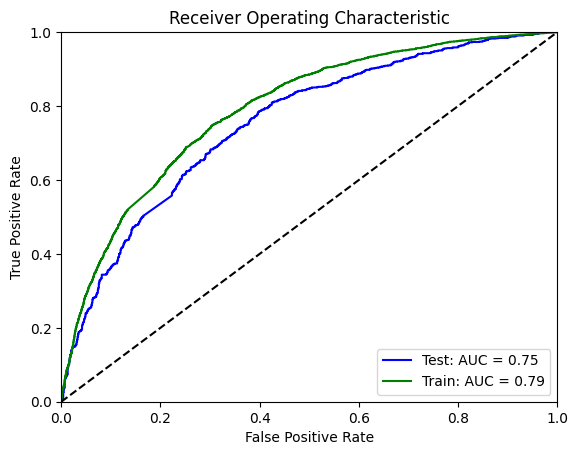

In [473]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr1, tpr1, threshold1 = roc_curve(y_test, proba_test)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, threshold2 = roc_curve(y_train, proba_train)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label='Test: AUC = {0:.2f}'.format(roc_auc1))
plt.plot(fpr2, tpr2, 'g', label='Train: AUC = {0:.2f}'.format(roc_auc2))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

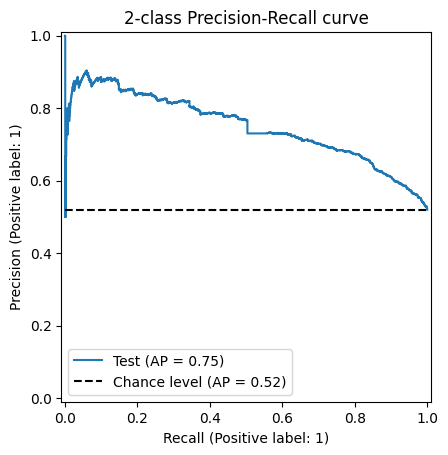

In [474]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    scorecard, X_test, y_test, name="Test", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Challenger Model
## XGBoost
### Boosted Trees can capture complex patterns and interactions between features and effectively model non-linear relationships between variables. Boosted Trees can provide high predictive accuracy and are robust to overfitting, especially when properly tuned.

In [475]:
df = df_original.copy()

features = ['estimate_of_risk', 'months_since_first_trade', 'months_since_last_trade', 'number_of_satisfactory_trades',
            'nr_trades_insolvent_for_over_90_days', 'percentage_of_legal_trades',
            'nr_inquiries_in_last_6_months', 'nr_banks_with_high_ratio']
X = df[features]
y = df['is_at_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [476]:
import xgboost as xgb

xgb_mod = xgb.XGBClassifier(objective='reg:logistic', colsample_bytree=0.2, alpha=10,
                            learning_rate=0.1, max_depth=4, n_estimators=100)
xgb_mod.fit(X_train,y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.2, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [477]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

xgb_pred = xgb_mod.predict(X_test)
print('Training accuracy:', accuracy_score(y_train, xgb_mod.predict(X_train)))
print('Test accuracy:', accuracy_score(y_test, xgb_pred))

Training accuracy: 0.7247520019122744
Test accuracy: 0.6983747609942639


In [478]:
proba_train_xgb = xgb_mod.predict_proba(X_train)[:, 1]
proba_test_xgb = xgb_mod.predict_proba(X_test)[:, 1]

print(f"AUC train:{round(roc_auc_score(y_train, proba_train),4)}")
print(f"AUC test :{round(roc_auc_score(y_test, proba_test),4)}\n")

print(classification_report(y_test, xgb_mod.predict(X_test)))

AUC train:0.7904
AUC test :0.7532

              precision    recall  f1-score   support

           0       0.70      0.65      0.67      1004
           1       0.70      0.74      0.72      1088

    accuracy                           0.70      2092
   macro avg       0.70      0.70      0.70      2092
weighted avg       0.70      0.70      0.70      2092



## According to the accuracy, recall and f1 scores, the XGBoost model performs only marginally better than the scorecard model.
## Therefore, the retrained scorecard model was chosen for deployment.

# Deployment

## Post Processing: Convert to Scores


Convert the probabilities to scores. [Credit scorecard development process](https://medium.com/@yanhuiliu104/credit-scoring-scorecard-development-process-8554c3492b2b)

In [479]:
from skorecard.rescale import calibrate_to_master_scale
import numpy as np

proba_train = pd.Series(proba_train, index=X_train.index).sort_values()

ref_score = 400
ref_odds = 3
pdo = 20

scores = calibrate_to_master_scale(proba_train, pdo=pdo, ref_score=ref_score, ref_odds=ref_odds)

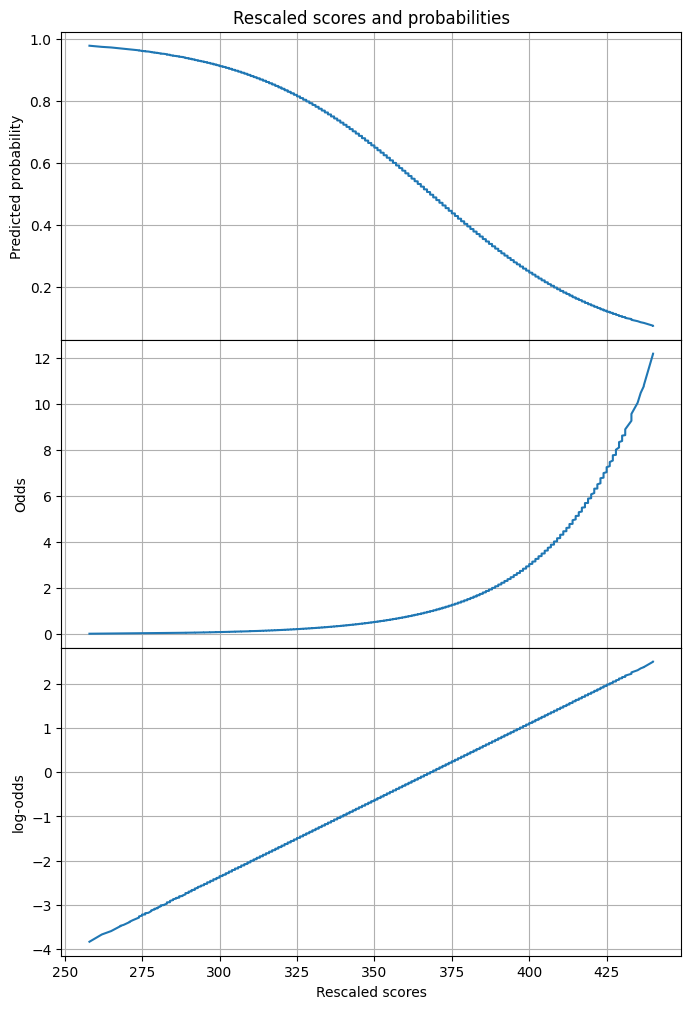

In [480]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(8, 12), gridspec_kw={"hspace": 0})
ax1.plot(scores.values, proba_train.values)

ax1.set_ylabel("Predicted probability")
ax1.set_title("Rescaled scores and probabilities")
ax1.grid()


ax2.plot(scores.values, proba_train.apply(lambda x: (1 - x) / x).values)
ax2.set_ylabel("Odds")
ax2.grid()


ax3.plot(
    scores.values,
    proba_train.apply(lambda x: np.log(1 - x) - np.log(x)).values,
)
ax3.set_ylabel("log-odds")
ax3.grid()
ax3.set_xlabel("Rescaled scores")

plt.show()

In [481]:
from skorecard.rescale import ScoreCardPoints

# ensure that pdo, ref_score and ref_odds are consistent
scp = ScoreCardPoints(skorecard_model=scorecard, pdo=20, ref_score=400, ref_odds=3)

In [482]:
scp.get_scorecard_points()

,bin_index,map,woe,feature,coef,contribution,Points
0,0,"(-inf, 59.4]",1.721205,estimate_of_risk,0.759356,1.307008,8
1,1,"(59.4, 63.0]",-0.479906,estimate_of_risk,0.759356,-0.364420,56
2,2,"(63.0, 67.19999999999999]",-0.867618,estimate_of_risk,0.759356,-0.658831,65
3,3,"(67.19999999999999, 70.19999999999999]",0.430220,estimate_of_risk,0.759356,0.326691,36
4,4,"(70.19999999999999, 74.4]",-0.063288,estimate_of_risk,0.759356,-0.048058,47
5,5,"(74.4, 77.4]",0.816943,estimate_of_risk,0.759356,0.620351,28
6,6,"(77.4, 80.4]",-1.740437,estimate_of_risk,0.759356,-1.321612,84
7,7,"(80.4, 83.4]",-1.125747,estimate_of_risk,0.759356,-0.854843,70
8,8,"(83.4, inf]",1.247368,estimate_of_risk,0.759356,0.947197,18
9,-1,Missing,0.000000,estimate_of_risk,0.759356,0.000000,46


In [483]:
df_score = scp.transform(X_test)
df_score['score'] = df_score.sum(axis=1, skipna=True)
df_score.head(10)

,estimate_of_risk,months_since_first_trade,months_since_last_trade,number_of_satisfactory_trades,nr_trades_insolvent_for_over_90_days,percentage_of_legal_trades,nr_inquiries_in_last_6_months,nr_banks_with_high_ratio,score
7528,36.0,29.0,46.0,46.0,52.0,42.0,46.0,52.0,349.0
7406,28.0,45.0,46.0,57.0,52.0,42.0,37.0,52.0,359.0
2473,8.0,48.0,46.0,53.0,52.0,37.0,43.0,52.0,339.0
1418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2150,84.0,45.0,46.0,42.0,52.0,42.0,37.0,41.0,389.0
7719,70.0,43.0,46.0,21.0,52.0,42.0,37.0,41.0,352.0
761,18.0,45.0,46.0,42.0,52.0,42.0,37.0,41.0,323.0
1950,28.0,29.0,46.0,21.0,52.0,42.0,46.0,52.0,316.0
10214,84.0,53.0,46.0,37.0,52.0,42.0,37.0,NaN,351.0
9292,18.0,45.0,46.0,45.0,52.0,37.0,37.0,41.0,321.0


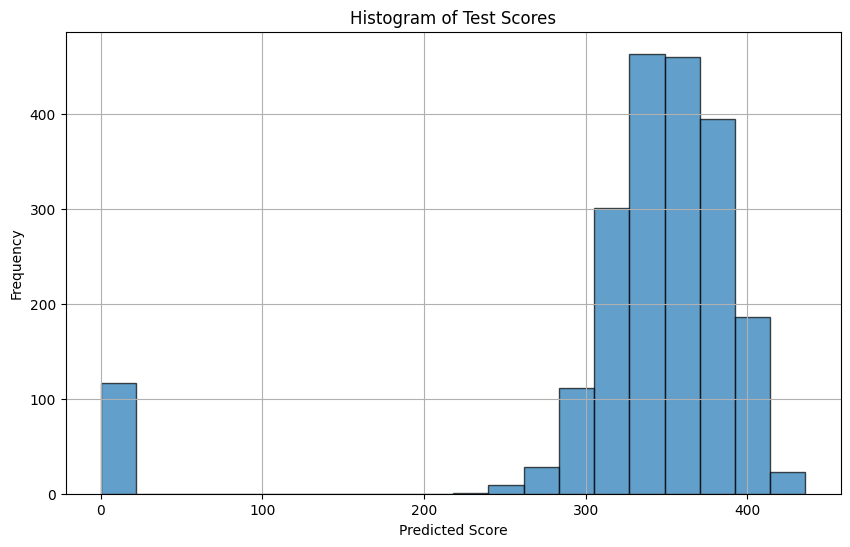

In [484]:
import matplotlib.pyplot as plt

# Create a histogram of the 'Score' column
plt.figure(figsize=(10, 6))
plt.hist(df_score['score'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Histogram of Test Scores')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

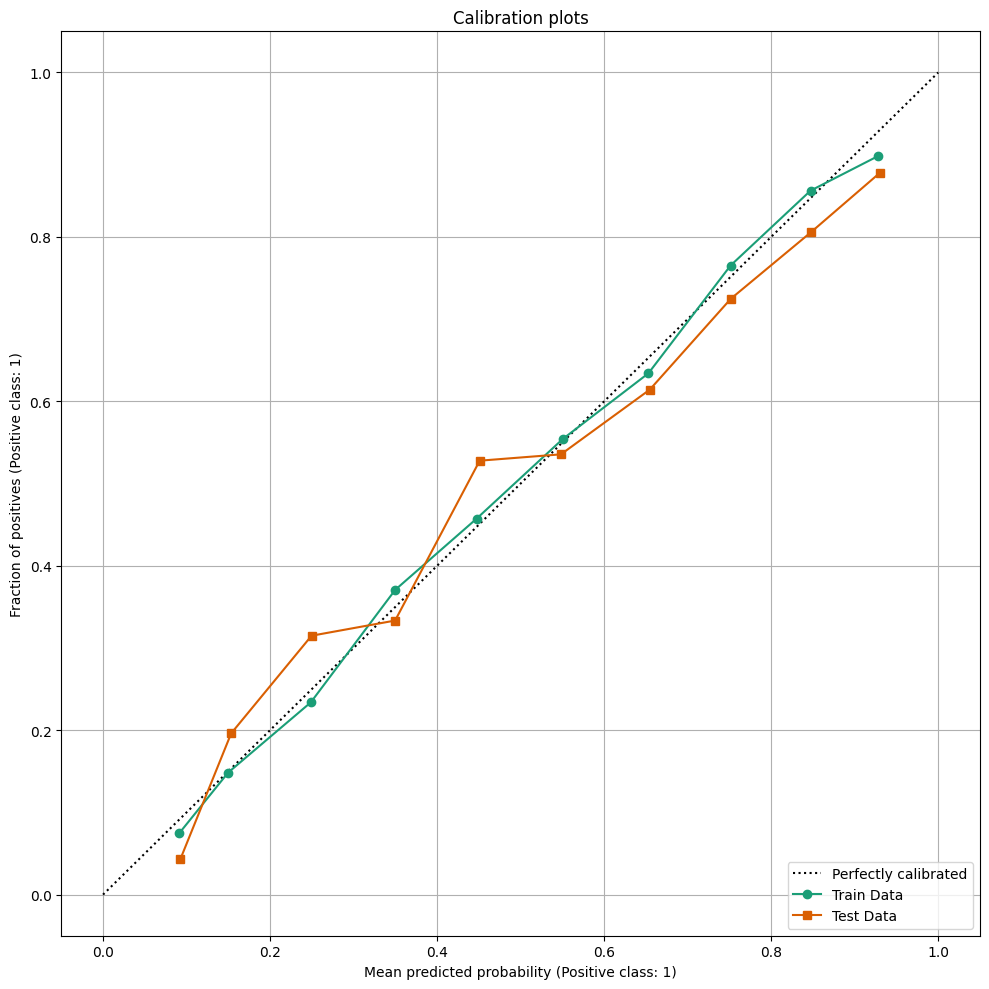

In [485]:
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

proba_train = scorecard.predict_proba(X_train)[:, 1]
proba_test = scorecard.predict_proba(X_test)[:, 1]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:, :])


calibration_display_train = CalibrationDisplay.from_predictions(
    y_train,
    proba_train,
    n_bins=10,
    name="Train Data",
    ax=ax_calibration_curve,
    color=colors(0),
    marker='o'
)

# Display calibration curve for test data
calibration_display_test = CalibrationDisplay.from_predictions(
    y_test,
    proba_test,
    n_bins=10,
    name="Test Data",
    ax=ax_calibration_curve,
    color=colors(1),
    marker='s'
)

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

plt.tight_layout()
plt.show()

# Interpretation

## According to the calibration plots, the model is relatively close to the perfect calibration line suggesting that both the training and test data are well-calibrated and the predicted probabilities from the model are close to the actual probabilities of the outcomes.

## There is a small gap between the train and test data which indicates that there is a minor difference between the calibration of the model on the training data and the test data meaning the model's performance on the training set is slightly different from its performance on the test set.

--------------------------------------------------------------------------------

#  Population Stability Index (PSI)
## Measures how much a population's characteristics have changed over time by comparing the distribution of variables in an original training dataset to a newer dataset. It helps determine if the predictive model is still relevant or if it needs updating.

## A low PSI score indicates stability, while a high score suggests significant population change that may require model recalibration or retraining.

| PSI | Interpretation     |
|:-----------------:|-----------------------------|
| PSI < 0.1 | No change. You can continue using existing model. |
| 0.1 <= PSI >= < 0.2 | Slight change is required. |
| PSI >=0.2 | Significant change is required. Ideally, you should not use this model anymore, retraining is required. |


In [486]:
from skorecard.bucketers import EqualWidthBucketer
from skorecard.reporting import psi

bucketer = EqualWidthBucketer()
bucketer.fit(X_train)

X_train_bins = bucketer.fit_transform(X_train)
X_test_bins = bucketer.transform(X_test)

psi_values = psi(X_train_bins, X_test_bins)
psi_values

{'estimate_of_risk': 0.0005851907063139687,
 'months_since_first_trade': 0.0035233075248032627,
 'months_since_last_trade': 0.0009795857491707205,
 'number_of_satisfactory_trades': 0.003622583221025449,
 'nr_trades_insolvent_for_over_90_days': 0.004366626786234931,
 'percentage_of_legal_trades': 0.0009073183436080451,
 'nr_inquiries_in_last_6_months': 0.0016285007885984625,
 'nr_banks_with_high_ratio': 0.002285490937895025}

# Interpretation

## Based on these PSI values, all variables show excellent stability, indicating the model's performance is likely very consistent over time.

## All PSI scores are well below 0.1, suggesting minimal shifts in the population characteristics.

## This implies that the model should maintain its predictive accuracy and reliability without immediate need for recalibration or retraining.



In [487]:
# define fpr_score, assign pos_label/neg_label, and create scoring
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, precision_score, recall_score

pos_label, neg_label = "bad", "good"

def fpr_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp)
    return 1 - tnr

tpr_score = recall_score  # TPR and recall are the same metric
scoring = {
    "precision": make_scorer(precision_score, pos_label=1),
    "recall": make_scorer(recall_score, pos_label=1),
    "fpr": make_scorer(fpr_score, neg_label=0, pos_label=1),
    "tpr": make_scorer(tpr_score, pos_label=1),
}

In [488]:
# define credit_gain_score (correctly updating gain_matrix) and run it

import numpy as np

def credit_gain_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    # The rows of the confusion matrix hold the counts of observed classes
    # while the columns hold counts of predicted classes. Recall that here we
    # consider "bad" as the positive class (second row and column).
    # Scikit-learn model selection tools expect that we follow a convention
    # that "higher" means "better", hence the following gain matrix assigns
    # negative gains (costs) to the two kinds of prediction errors:
    # - a gain of -1 for each false positive ("good" credit labeled as "bad"),
    # - a gain of -5 for each false negative ("bad" credit labeled as "good"),
    # The true positives and true negatives are assigned null gains in this
    # metric.
    #
    # Note that theoretically, given that our model is calibrated and our data
    # set representative and large enough, we do not need to tune the
    # threshold, but can safely set it to the cost ration 1/5, as stated by Eq.
    # (2) in Elkan paper [2]_.
    gain_matrix = np.array(
        [
            [0, -1],  # -1 gain for false positives
            [-5, 0],  # -5 gain for false negatives
        ]
    )
    return np.sum(cm * gain_matrix)


scoring["cost_gain"] = make_scorer(
    credit_gain_score, neg_label=0, pos_label=1
)

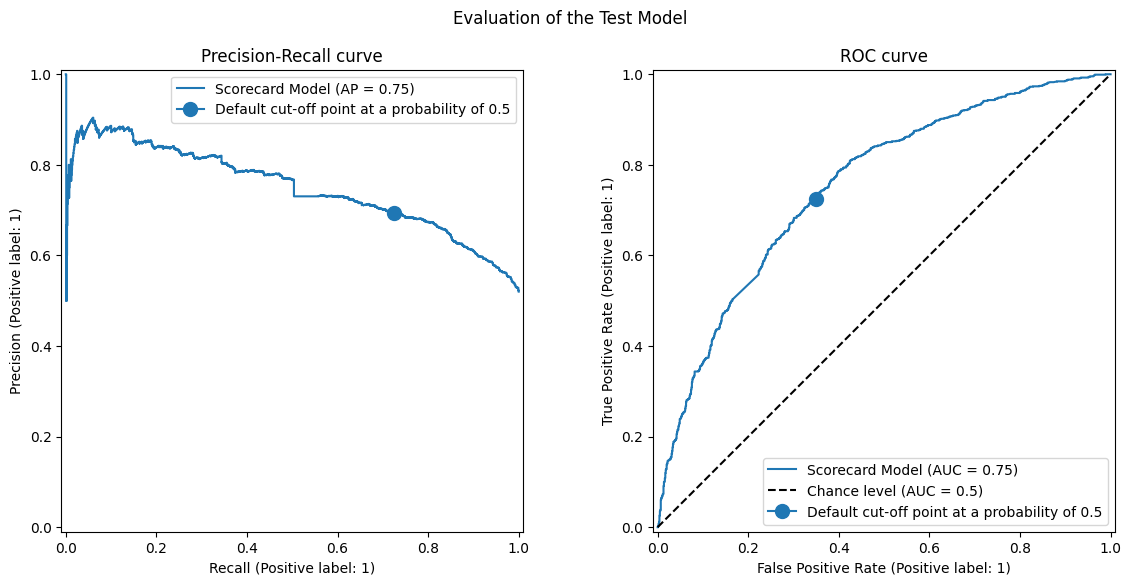

In [489]:
# plot Precision-Recall at 50% using PrecisionRecallDisplay and RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

model = scorecard

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, pos_label=1, ax=axs[0], name="Scorecard Model"
)
axs[0].plot(
    scoring["recall"](model, X_test, y_test),
    scoring["precision"](model, X_test, y_test),
    marker="o",
    markersize=10,
    color="tab:blue",
    label="Default cut-off point at a probability of 0.5",
)
axs[0].set_title("Precision-Recall curve")
axs[0].legend()

RocCurveDisplay.from_estimator(
    model,
    X_test,
    y_test,
    pos_label=1,
    ax=axs[1],
    name="Scorecard Model",
    plot_chance_level=True,
)
axs[1].plot(
    scoring["fpr"](model, X_test, y_test),
    scoring["tpr"](model, X_test, y_test),
    marker="o",
    markersize=10,
    color="tab:blue",
    label="Default cut-off point at a probability of 0.5",
)
axs[1].set_title("ROC curve")
axs[1].legend()
_ = fig.suptitle("Evaluation of the Test Model")

In [490]:
# Using TunedThresholdClassifierCV to tune threshold
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=scoring["cost_gain"],
    store_cv_results=True,  # necessary to inspect all results
)
tuned_model.fit(X_train, y_train)
print(f"{tuned_model.best_threshold_=:0.2f}")

tuned_model.best_threshold_=0.17


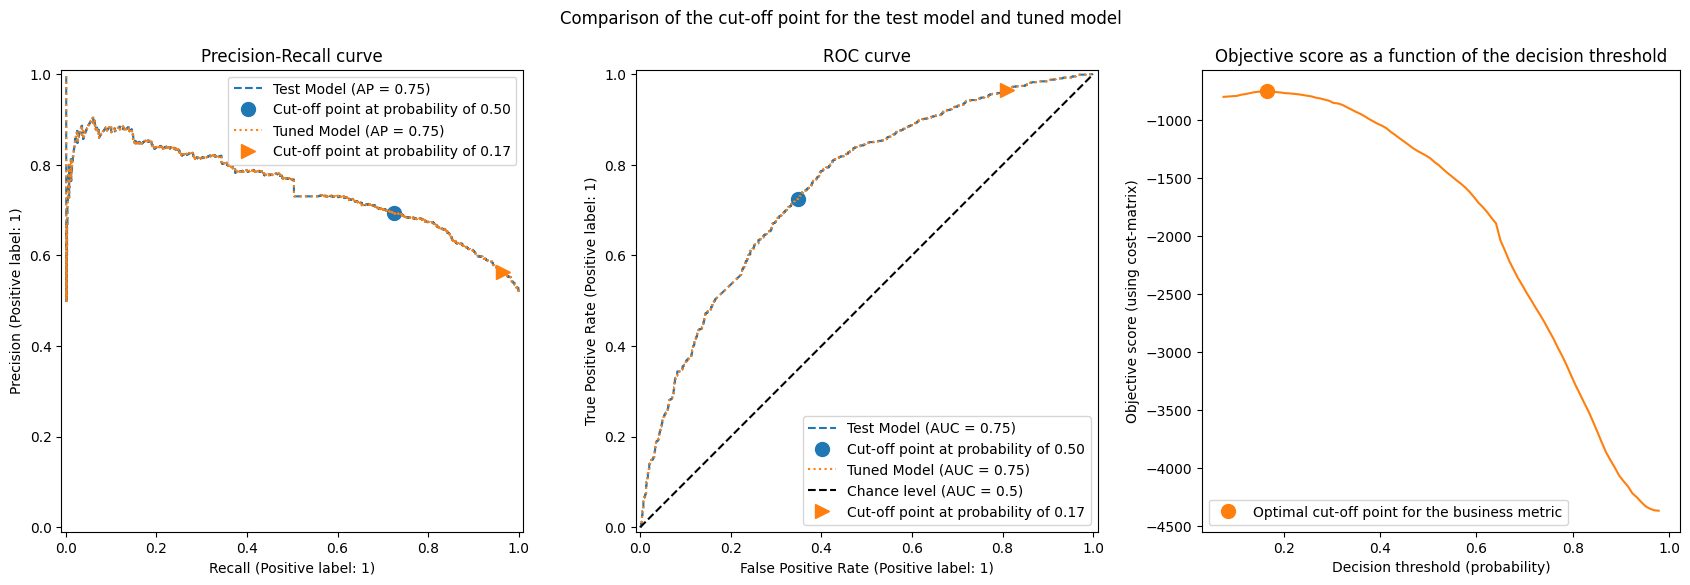

In [491]:
# define and run plot_roc_pr_curves
def plot_roc_pr_curves(model, tuned_model, *, title):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

    linestyles = ("dashed", "dotted")
    markerstyles = ("o", ">")
    colors = ("tab:blue", "tab:orange")
    names = ("Test Model", "Tuned Model")
    for idx, (est, linestyle, marker, color, name) in enumerate(
        zip((model, tuned_model), linestyles, markerstyles, colors, names)
    ):
        decision_threshold = getattr(est, "best_threshold_", 0.5)
        PrecisionRecallDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=1,
            linestyle=linestyle,
            color=color,
            ax=axs[0],
            name=name,
        )
        axs[0].plot(
            scoring["recall"](est, X_test, y_test),
            scoring["precision"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )
        RocCurveDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=1,
            linestyle=linestyle,
            color=color,
            ax=axs[1],
            name=name,
            plot_chance_level=idx == 1,
        )
        axs[1].plot(
            scoring["fpr"](est, X_test, y_test),
            scoring["tpr"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )

    axs[0].set_title("Precision-Recall curve")
    axs[0].legend()
    axs[1].set_title("ROC curve")
    axs[1].legend()

    axs[2].plot(
        tuned_model.cv_results_["thresholds"],
        tuned_model.cv_results_["scores"],
        color="tab:orange",
    )
    axs[2].plot(
        tuned_model.best_threshold_,
        tuned_model.best_score_,
        "o",
        markersize=10,
        color="tab:orange",
        label="Optimal cut-off point for the business metric",
    )
    axs[2].legend()
    axs[2].set_xlabel("Decision threshold (probability)")
    axs[2].set_ylabel("Objective score (using cost-matrix)")
    axs[2].set_title("Objective score as a function of the decision threshold")
    fig.suptitle(title)

title = "Comparison of the cut-off point for the test model and tuned model"
plot_roc_pr_curves(model, tuned_model, title=title)

# Interpretation

- ## Average Precision (AP) for both the test set and the tuned model is the same at 0.75 and suggests that the model performs consistently across these different scenarios.

- ## Model Consistency: The same AP value for both test and tuned models indicates that the model is performing consistently well. The tuning process did not lead to overfitting or significant underfitting.

- ## Generalization: Since the performance is similar across the training and test datasets, the model appears to generalize well to unseen data. This consistency suggests that the model has captured the underlying patterns in the data effectively.

- ## Model Robustness: Achieving the same AP for both the test set and the tuned model suggests robustness in the model. It means that the model's performance is stable and not heavily dependent on specific subsets of data.

- ##  As mentioned previously when discussing the the small differences between the train and test event rates. After further analysis, those do not seem to significantly impact the overall performance of the model as measured by the AP. This further indicates that the model is robust to these variations.

# Future Work:

- ## Feature Engineering: create new features by combining existing ones or deriving new metrics. This can help uncover hidden patterns and improve model performance.
## Examples:
  - ## Trade activity ratio: Divide 'number_of_satisfactory_trades' by 'months_since_first_trade'. This could indicate the frequency of positive trade activity over time.
  - ## Risk-adjusted trade score: Multiply 'estimate_of_risk' by (1 - 'percentage_of_legal_trades'). This combines risk estimate with legal compliance.
  - ## Recent activity indicator: Create a binary feature that's 1 if 'months_since_last_trade' is less than a certain threshold (3 months), 0 otherwise. This could highlight recently active accounts.

- ## Model Experimentation: Trying different ML algorithms like PCA and SVM and implementing ensemble methods to combine multiple models which can often lead to better overall performance than relying on a single algorithm.

- ## Hyperparameter Tuning: Instead of Cross Validation, using Bayesian Optimization with cross-validation to fine-tune the model parameters.